In [ ]:
pip uninstall scikit-learn -y

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2


In [ ]:
!pip install scikit-learn~=1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 58.9 MB/s eta 0:00:00


In [ ]:
#you need restart the session after you install it
!pip install matminer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 51.6 MB/s eta 0:00:00


In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data
from pymatgen.core import Element
from sklearn.preprocessing import StandardScaler
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import random


# Function to set the random seed for reproducibility
def set_seed(seed):
    # Set random seed for Python
    random.seed(seed)

    # Set random seed for NumPy
    np.random.seed(seed)

    # Set random seed for PyTorch
    torch.manual_seed(seed)

# Call the set_seed function before training to ensure reproducibility
set_seed(42)

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/proj_1_Li_battery/cleaned_final_Parsed_mpcules_crystalline_molecules_filtered.csv')

# List of target columns (these will be excluded from input features)
target_columns = ['electronic_energy_Ha', 'total_enthalpy_kcal_mol', 'total_entropy_cal_molK', 'free_energy_eV', 'vibration_frequencies_avg']

# Convert the 'free_energy_eV' column in the target columns from eV to keV
df['free_energy_keV'] = df['free_energy_eV'] * 0.001

# Update the target_columns to reflect the new unit for free energy
target_columns = ['electronic_energy_Ha', 'total_enthalpy_kcal_mol', 'total_entropy_cal_molK', 'free_energy_keV', 'vibration_frequencies_avg']

# Extract all feature columns (those that are not target columns or 'molecule_graph')
feature_columns = [col for col in df.columns if col not in target_columns and col != 'molecule_graph']

# Ensure we only use columns that exist in the dataset
available_numeric_columns = ['charge', 'spin_multiplicity']  # Updated to use available columns

# Normalize the target values (y) with free energy in keV
y = df[target_columns].values
scaler_y = StandardScaler()
y_normalized = scaler_y.fit_transform(y)

# Function to parse the molecule graph representation
def parse_molecule_graph(graph_str):
    # Split the string representation into lines
    lines = graph_str.splitlines()

    atoms = []  # Store atom information (species)
    bonds = []  # Store bond information (edges)

    # Extract atoms (sites) from the graph string
    for line in lines:
        if line.startswith("Site:"):
            # Use regex to extract the element name (like 'C', 'N', 'F')
            element = re.search(r'Site: (\w+)', line).group(1)
            atoms.append(Element(element).Z)  # Convert element to atomic number

    # Extract bond information after the "from    to" section starts
    if "from    to  to_image      weight" in lines:
        bond_start_idx = lines.index("from    to  to_image      weight") + 1
        for line in lines[bond_start_idx:]:
            bond_parts = line.split()
            if bond_parts[0].isdigit():
                from_idx = int(bond_parts[0])
                to_idx = int(bond_parts[1])
                bonds.append([from_idx, to_idx])  # Append the bond (undirected)

    return atoms, bonds

# Function to convert the parsed graph representation and 'bonds' into PyTorch Geometric Data
def graph_to_pyg(row):
    try:
        # Parse atoms and bonds from the graph string
        atoms, bonds = parse_molecule_graph(row['molecule_graph'])

        # Convert atom features (atomic number + numeric features)
        atom_features = []
        for atomic_number in atoms:
            node_features = [atomic_number]  # Start with atomic number as node feature
            # Add any available numeric features for each atom
            node_features.extend(row[available_numeric_columns].values)
            atom_features.append(node_features)

        # Convert bonds to edge indices (undirected graph)
        edge_index = []
        for bond in bonds:
            edge_index.append([bond[0], bond[1]])
            edge_index.append([bond[1], bond[0]])  # Undirected bond

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        x = torch.tensor(atom_features, dtype=torch.float)

        return Data(x=x, edge_index=edge_index)

    except Exception as e:
        print(f"Error converting graph to PyTorch Geometric Data: {e}")
        return None

# Apply the graph_to_pyg conversion using 'molecule_graph' and 'bonds'
df['pyg_graph'] = df.apply(lambda row: graph_to_pyg(row), axis=1)

# Drop rows with invalid graphs
df = df.dropna(subset=['pyg_graph'])

# Ensure we have valid graphs before proceeding
if df.empty:
    raise ValueError("No valid graph data was found after parsing.")

# Extract the PyG Data objects for training
graph_data = df['pyg_graph'].tolist()

# Split the dataset into training and test sets
train_graphs, test_graphs, train_targets, test_targets = train_test_split(graph_data, y_normalized, test_size=0.2, random_state=42)

# Custom Dataset class for PyTorch Geometric
class MoleculeDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, targets):
        self.graphs = graphs
        self.targets = targets

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], torch.tensor(self.targets[idx], dtype=torch.float)

# Prepare datasets and dataloaders
train_dataset = MoleculeDataset(train_graphs, train_targets)
test_dataset = MoleculeDataset(test_graphs, test_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# GNN model definition with an additional GCN layer
class GNNModel(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)  # Additional GCN Layer
        self.fc1 = torch.nn.Linear(hidden_channels, 64)
        self.fc2 = torch.nn.Linear(64, len(target_columns))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)  # Pass through the new GCN layer
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model with the number of node features (atomic number + available numeric features)
model = GNNModel(hidden_channels=64, num_node_features=len(available_numeric_columns) + 1)  # +1 for atomic number

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train():
    model.train()
    total_loss = 0
    for data, targets in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Testing function
def test():
    model.eval()
    total_loss = 0
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, targets in test_loader:
            out = model(data)
            loss = F.mse_loss(out, targets)
            total_loss += loss.item()
            predictions.append(out.cpu().numpy())
            actuals.append(targets.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    return total_loss / len(test_loader), predictions, actuals

# Training loop
train_losses = []
test_losses = []

for epoch in range(300):  # Run for 300 epochs
    train_loss = train()
    test_loss, predictions, actuals = test()

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss}, Test Loss: {test_loss}')

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/proj_1_Li_battery/gnn_model_300_validation_dataset.pth')

# Convert predictions and actuals back to their original scale
predictions_original = scaler_y.inverse_transform(predictions)
actuals_original = scaler_y.inverse_transform(actuals)

# Evaluate metrics for each target
for i, target_name in enumerate(target_columns):
    r2 = r2_score(actuals_original[:, i], predictions_original[:, i])
    mae = mean_absolute_error(actuals_original[:, i], predictions_original[:, i])
    rmse = np.sqrt(mean_squared_error(actuals_original[:, i], predictions_original[:, i]))
    pearson = pearsonr(actuals_original[:, i], predictions_original[:, i])[0]

    print(f'\nMetrics for {target_name} (original scale):')
    print(f'R-squared: {r2}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Pearson Correlation: {pearson}')

# Plot Actual vs Predicted for each target with updated titles for publication
plt.figure(figsize=(14, 12))

# Dictionary to provide descriptive plot titles
plot_titles = {
    'electronic_energy_Ha': 'Electronic Energy (Ha)',
    'total_enthalpy_kcal_mol': 'Total Enthalpy (kcal/mol)',
    'total_entropy_cal_molK': 'Total Entropy (cal/mol·K)',
    'free_energy_keV': 'Free Energy (keV)',
    'vibration_frequencies_avg': 'Average Vibration Frequencies (cm$^{-1}$)'
}

for i, target_name in enumerate(target_columns):
    plt.subplot(2, 3, i + 1)
    plt.scatter(actuals_original[:, i], predictions_original[:, i], alpha=0.6)
    plt.plot([actuals_original[:, i].min(), actuals_original[:, i].max()],
             [actuals_original[:, i].min(), actuals_original[:, i].max()], 'k--', lw=3)
    plt.xlabel(f'Actual {plot_titles[target_name]}')
    plt.ylabel(f'Predicted {plot_titles[target_name]}')
    plt.title(f'{plot_titles[target_name]}')

# Global title
plt.suptitle('GNN Model Predictions for Li-Ion Battery Properties Electrolytes Using Test Data from Validation Dataset', fontsize=16)

# Adjust layout to prevent overlapping titles
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('/content/drive/MyDrive/proj_1_Li_battery/actual_vs_predicted_plots_gnn_300_validation_set.png', dpi=300)
plt.show()

# Plot the learning curve (Train and Test Loss over epochs)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for GNN Model on LIB Electrolytes Properties Using Test Data from Validation Dataset', fontsize=16)
plt.legend()

# Save the learning curve figure
plt.savefig('/content/drive/MyDrive/proj_1_Li_battery/learning_curve_gnn_300_validation_set.png', dpi=300)
plt.show()


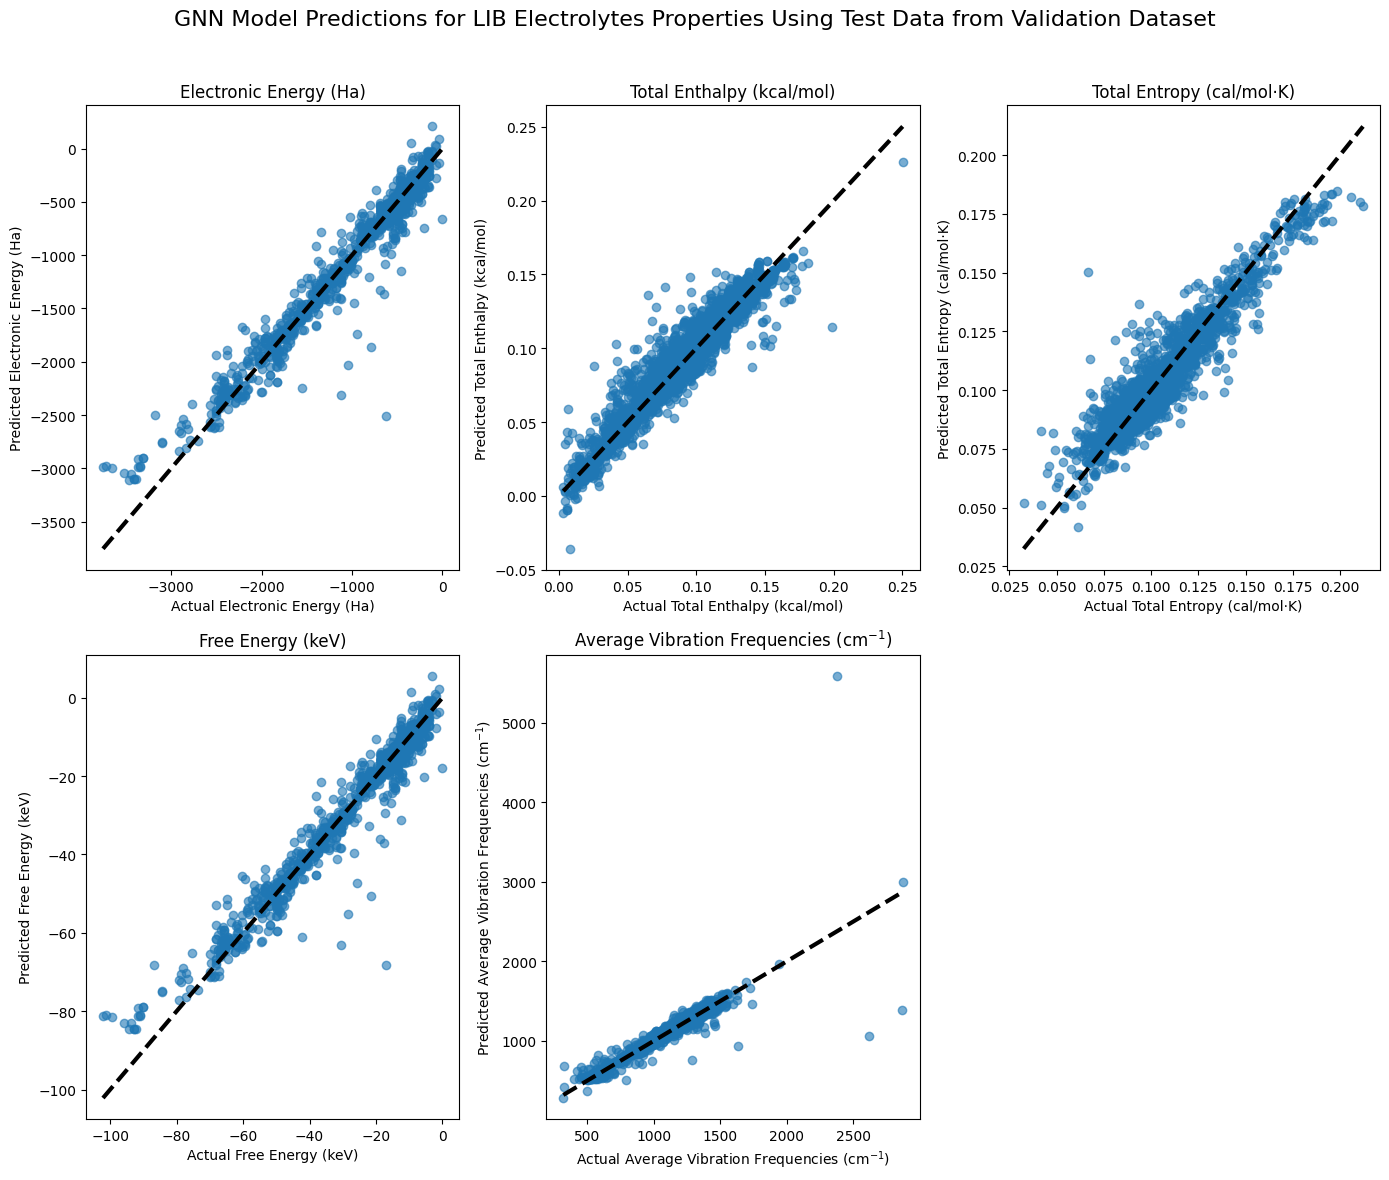

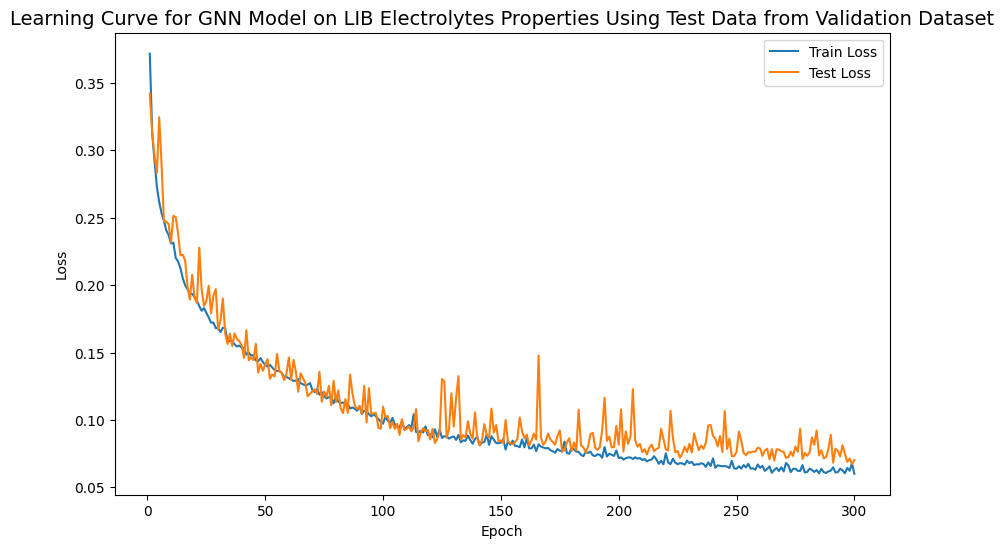

In [ ]:
# Plot Actual vs Predicted for each target with updated titles for publication
plt.figure(figsize=(14, 12))

# Dictionary to provide descriptive plot titles
plot_titles = {
    'electronic_energy_Ha': 'Electronic Energy (Ha)',
    'total_enthalpy_kcal_mol': 'Total Enthalpy (kcal/mol)',
    'total_entropy_cal_molK': 'Total Entropy (cal/mol·K)',
    'free_energy_keV': 'Free Energy (keV)',
    'vibration_frequencies_avg': 'Average Vibration Frequencies (cm$^{-1}$)'
}

for i, target_name in enumerate(target_columns):
    plt.subplot(2, 3, i + 1)
    plt.scatter(actuals_original[:, i], predictions_original[:, i], alpha=0.6)
    plt.plot([actuals_original[:, i].min(), actuals_original[:, i].max()],
             [actuals_original[:, i].min(), actuals_original[:, i].max()], 'k--', lw=3)
    plt.xlabel(f'Actual {plot_titles[target_name]}')
    plt.ylabel(f'Predicted {plot_titles[target_name]}')
    plt.title(f'{plot_titles[target_name]}')

# Global title
plt.suptitle('GNN Model Predictions for LIB Electrolytes Properties Using Test Data from Validation Dataset', fontsize=16)

# Adjust layout to prevent overlapping titles
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('/content/drive/MyDrive/proj_1_Li_battery/actual_vs_predicted_plots_gnn_300_validation_set.png', dpi=300)
plt.show()

# Plot the learning curve (Train and Test Loss over epochs)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for GNN Model on LIB Electrolytes Properties Using Test Data from Validation Dataset', fontsize=14)
plt.legend()

# Save the learning curve figure
plt.savefig('/content/drive/MyDrive/proj_1_Li_battery/learning_curve_gnn_300_validation_set.png', dpi=300)
plt.show()

In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from pymatgen.core import Element
from sklearn.preprocessing import StandardScaler
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import random


# Function to set the random seed for reproducibility
def set_seed(seed):
    # Set random seed for Python
    random.seed(seed)

    # Set random seed for NumPy
    np.random.seed(seed)

    # Set random seed for PyTorch
    torch.manual_seed(seed)

# Call the set_seed function before training to ensure reproducibility
set_seed(42)

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/proj_1_Li_battery/cleaned_final_Parsed_mpcules_crystalline_molecules_filtered.csv')

# List of target columns (these will be excluded from input features)
target_columns = ['electronic_energy_Ha', 'total_enthalpy_kcal_mol', 'total_entropy_cal_molK', 'free_energy_eV', 'vibration_frequencies_avg']

# Convert the 'free_energy_eV' column in the target columns from eV to keV
df['free_energy_keV'] = df['free_energy_eV'] * 0.001

# Update the target_columns to reflect the new unit for free energy
target_columns = ['electronic_energy_Ha', 'total_enthalpy_kcal_mol', 'total_entropy_cal_molK', 'free_energy_keV', 'vibration_frequencies_avg']

# Normalize the target values (y) with free energy in keV
y = df[target_columns].values
scaler_y = StandardScaler()
y_normalized = scaler_y.fit_transform(y)

# Function to parse molecule graph representation
def parse_molecule_graph(graph_str):
    lines = graph_str.splitlines()
    atoms = []
    bonds = []
    for line in lines:
        if line.startswith("Site:"):
            element = re.search(r'Site: (\w+)', line).group(1)
            atoms.append(Element(element).Z)
    if "from    to  to_image      weight" in lines:
        bond_start_idx = lines.index("from    to  to_image      weight") + 1
        for line in lines[bond_start_idx:]:
            bond_parts = line.split()
            if bond_parts[0].isdigit():
                from_idx = int(bond_parts[0])
                to_idx = int(bond_parts[1])
                bonds.append([from_idx, to_idx])
    return atoms, bonds

# Convert graph representation into PyTorch Geometric Data format
def graph_to_pyg(row):
    try:
        atoms, bonds = parse_molecule_graph(row['molecule_graph'])
        atom_features = []
        for atomic_number in atoms:
            node_features = [atomic_number]  # Atomic number as node feature
            # Add additional numeric features (like charge, spin_multiplicity if available)
            node_features.extend([row['charge'], row['spin_multiplicity']])
            atom_features.append(node_features)
        edge_index = []
        for bond in bonds:
            edge_index.append([bond[0], bond[1]])
            edge_index.append([bond[1], bond[0]])
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        x = torch.tensor(atom_features, dtype=torch.float)
        return Data(x=x, edge_index=edge_index)
    except Exception as e:
        print(f"Error converting graph to PyTorch Geometric Data: {e}")
        return None

# Apply the graph_to_pyg conversion and filter out invalid graphs
df['pyg_graph'] = df.apply(lambda row: graph_to_pyg(row), axis=1)
df = df.dropna(subset=['pyg_graph'])

# Extract the PyG Data objects for training
graph_data = df['pyg_graph'].tolist()

# Split the dataset into training and test sets
train_graphs, test_graphs, train_targets, test_targets = train_test_split(graph_data, y_normalized, test_size=0.2, random_state=42)

# Custom Dataset class for PyTorch Geometric
class MoleculeDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, targets):
        self.graphs = graphs
        self.targets = targets

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], torch.tensor(self.targets[idx], dtype=torch.float)

# Prepare datasets and dataloaders
train_dataset = MoleculeDataset(train_graphs, train_targets)
test_dataset = MoleculeDataset(test_graphs, test_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# GNN model definition
class GNNModel(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)  # Additional GCN Layer
        self.fc1 = torch.nn.Linear(hidden_channels, 64)
        self.fc2 = torch.nn.Linear(64, len(target_columns))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load the pre-trained model with the correct input feature size (atomic number + charge + spin_multiplicity = 3)
model = GNNModel(hidden_channels=64, num_node_features=3)  # 3 input features: atomic number, charge, spin multiplicity
model.load_state_dict(torch.load('/content/drive/MyDrive/proj_1_Li_battery/gnn_model_300_validation_dataset.pth'))
model.eval()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Active learning loop
def active_learning_loop(model, train_graphs, train_targets, test_graphs, test_targets, n_steps=300):
    train_losses, test_losses = [], []

    for step in range(n_steps):
        train_loader = DataLoader(MoleculeDataset(train_graphs, train_targets), batch_size=32, shuffle=True)
        test_loader = DataLoader(MoleculeDataset(test_graphs, test_targets), batch_size=32, shuffle=False)

        # Training
        model.train()
        total_train_loss = 0
        for data, targets in train_loader:
            optimizer.zero_grad()
            out = model(data)
            loss = F.mse_loss(out, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_losses.append(total_train_loss / len(train_loader))

        # Testing
        model.eval()
        total_test_loss = 0
        actuals, predictions = [], []
        with torch.no_grad():
            for data, targets in test_loader:
                out = model(data)
                loss = F.mse_loss(out, targets)
                total_test_loss += loss.item()
                predictions.append(out.cpu().numpy())
                actuals.append(targets.cpu().numpy())

        predictions = np.concatenate(predictions, axis=0)
        actuals = np.concatenate(actuals, axis=0)
        test_losses.append(total_test_loss / len(test_loader))

        print(f'Step {step + 1}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}')

        # Active learning strategy: Calculate uncertainties
        uncertainties = np.abs(predictions - actuals)

        # Maximum Uncertainty (MU)
        mu_selection = np.argmax(uncertainties[:, 0])  # Focus on uncertainty for first target

        # Add the most uncertain sample to the training set
        train_graphs.append(test_graphs[mu_selection])
        train_targets = np.vstack((train_targets, test_targets[mu_selection]))
        test_graphs.pop(mu_selection)
        test_targets = np.delete(test_targets, mu_selection, axis=0)

    return train_losses, test_losses, predictions, actuals

# Run the active learning loop
train_losses, test_losses, predictions, actuals = active_learning_loop(model, train_graphs, train_targets, test_graphs, test_targets, n_steps=300)

# Convert predictions and actuals back to original scale
predictions_original = scaler_y.inverse_transform(predictions)
actuals_original = scaler_y.inverse_transform(actuals)

# Convert 'free_energy_keV' back to eV in the final outputs for plotting purposes
#predictions_original[:, 3] = predictions_original[:, 3] * 1000  # Convert keV back to eV
#actuals_original[:, 3] = actuals_original[:, 3] * 1000  # Convert keV back to eV

# Dictionary for better plot titles
plot_titles = {
    'electronic_energy_Ha': 'Electronic Energy (Ha)',
    'total_enthalpy_kcal_mol': 'Total Enthalpy (kcal/mol)',
    'total_entropy_cal_molK': 'Total Entropy (cal/mol·K)',
    'free_energy_keV': 'Free Energy (keV)',  # Already converted in plotting
    'vibration_frequencies_avg': 'Average Vibration Frequencies (cm$^{-1}$)'
}

# Evaluate metrics for each target and print results
for i, target_name in enumerate(target_columns):
    if target_name == 'free_energy_keV':  # Convert to keV for display
        target_name = 'free_energy_keV'

    r2 = r2_score(actuals_original[:, i], predictions_original[:, i])
    mae = mean_absolute_error(actuals_original[:, i], predictions_original[:, i])
    rmse = np.sqrt(mean_squared_error(actuals_original[:, i], predictions_original[:, i]))
    pearson = pearsonr(actuals_original[:, i], predictions_original[:, i])[0]

    print(f'\nMetrics for {plot_titles[target_name]}:')
    print(f'R-squared: {r2}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Pearson Correlation: {pearson}')

# Plot Actual vs Predicted for each target
plt.figure(figsize=(12, 10))
for i, target_name in enumerate(target_columns):
    plt.subplot(2, 3, i + 1)
    plt.scatter(actuals_original[:, i], predictions_original[:, i], alpha=0.6)
    plt.plot([actuals_original[:, i].min(), predictions_original[:, i].max()],
             [actuals_original[:, i].min(), actuals_original[:, i].max()], 'k--', lw=3)
    plt.xlabel(f'Actual {plot_titles[target_name]}')
    plt.ylabel(f'Predicted {plot_titles[target_name]}')
    plt.title(f'{plot_titles[target_name]}')

# Global title
plt.suptitle('Active-Learning Model Predictions for LIB Electrolytes Properties Electrolytes Using Test Data from Validation Dataset', fontsize=16)

# Adjust layout to prevent overlapping titles
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('/content/drive/MyDrive/proj_1_Li_battery/actual_vs_predicted_plots_gnn_active_learning_300_validation_dataset.png', dpi=300)
plt.show()

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Active Learning Steps')
plt.ylabel('Loss')
plt.title('Learning Curve for Active Learning Model on LIB Electrolytes Properties Using Validation Dataset', fontsize=16)
plt.legend()

# Save the learning curve
plt.savefig('/content/drive/MyDrive/proj_1_Li_battery/learning_curve_gnn_active_learning_300_validation_dataset.png', dpi=300)
plt.show()

# Save the final trained model after active learning
torch.save(model.state_dict(), '/content/drive/MyDrive/proj_1_Li_battery/gnn_model_active_learning_final_validate_dataset_300.pth')

print("Model saved successfully!")



Metrics for Electronic Energy:
R-squared: 0.9728970527648926
Mean Absolute Error: 22.65226173400879
Root Mean Squared Error: 32.83776092529297
Pearson Correlation: 0.98689929213294

Metrics for Total Enthalpy:
R-squared: 0.9382723569869995
Mean Absolute Error: 0.0043205562978982925
Root Mean Squared Error: 0.005847918801009655
Pearson Correlation: 0.9686901268851507

Metrics for Total Entropy:
R-squared: 0.8602746725082397
Mean Absolute Error: 0.0030474422965198755
Root Mean Squared Error: 0.0041202944703400135
Pearson Correlation: 0.9282278758682032

Metrics for Free Energy:
R-squared: 0.9729085564613342
Mean Absolute Error: 0.616263210773468
Root Mean Squared Error: 0.8934095501899719
Pearson Correlation: 0.9869049757205586

Metrics for Average Vibration Frequencies:
R-squared: 0.9682939648628235
Mean Absolute Error: 13.935249328613281
Root Mean Squared Error: 21.637847900390625
Pearson Correlation: 0.9842407372352937


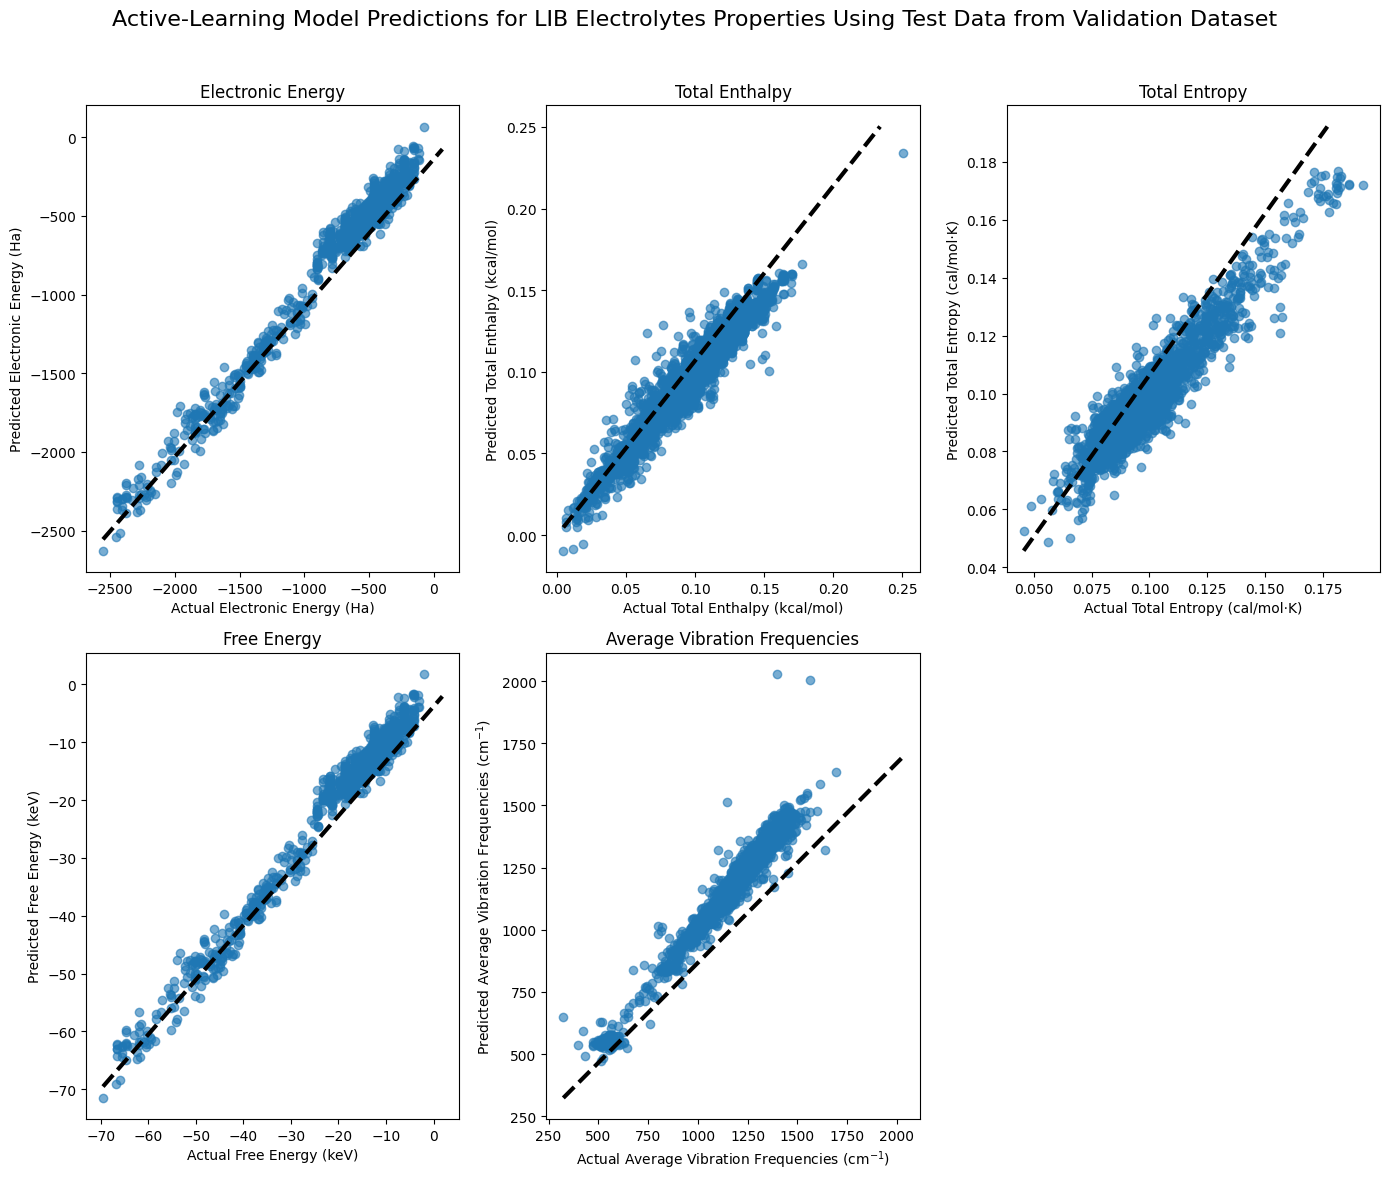

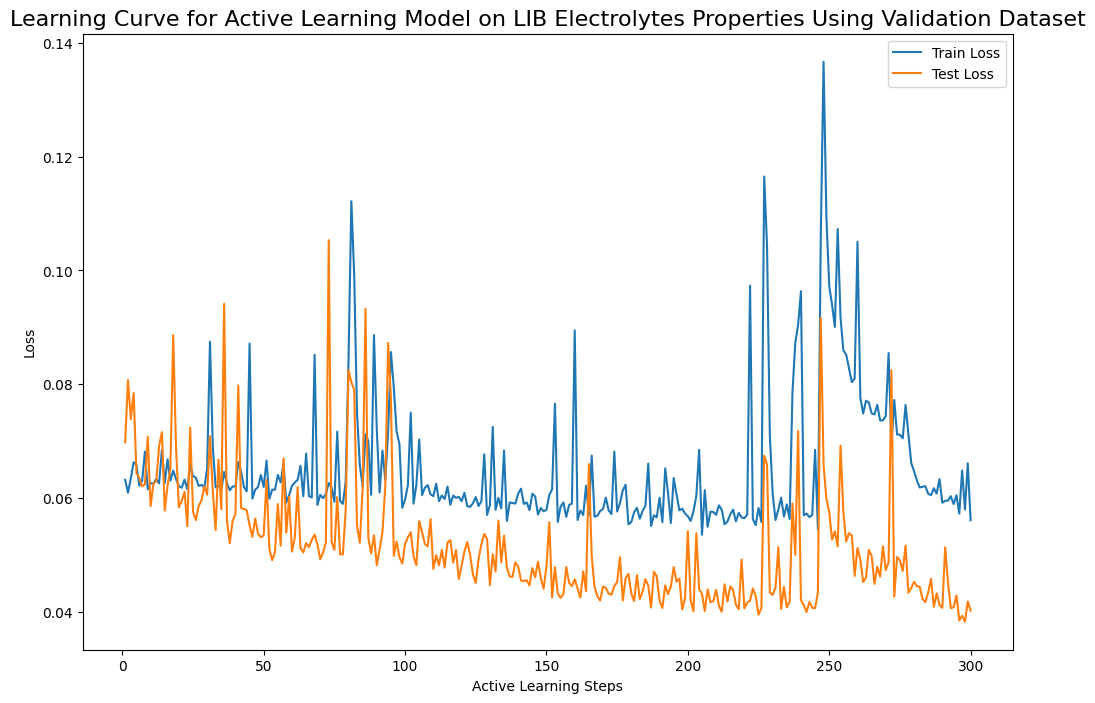

In [ ]:
# Dictionary for better plot titles (without units)
plot_titles_no_units = {
    'electronic_energy_Ha': 'Electronic Energy',
    'total_enthalpy_kcal_mol': 'Total Enthalpy',
    'total_entropy_cal_molK': 'Total Entropy',
    'free_energy_keV': 'Free Energy',
    'vibration_frequencies_avg': 'Average Vibration Frequencies'
}

# Dictionary for axis labels (with units)
axis_labels_with_units = {
    'electronic_energy_Ha': 'Electronic Energy (Ha)',
    'total_enthalpy_kcal_mol': 'Total Enthalpy (kcal/mol)',
    'total_entropy_cal_molK': 'Total Entropy (cal/mol·K)',
    'free_energy_keV': 'Free Energy (keV)',  # Already converted in plotting
    'vibration_frequencies_avg': 'Average Vibration Frequencies (cm$^{-1}$)'
}

# Evaluate metrics for each target and print results
for i, target_name in enumerate(target_columns):
    if target_name == 'free_energy_keV':  # Convert to keV for display
        target_name = 'free_energy_keV'

    r2 = r2_score(actuals_original[:, i], predictions_original[:, i])
    mae = mean_absolute_error(actuals_original[:, i], predictions_original[:, i])
    rmse = np.sqrt(mean_squared_error(actuals_original[:, i], predictions_original[:, i]))
    pearson = pearsonr(actuals_original[:, i], predictions_original[:, i])[0]

    print(f'\nMetrics for {plot_titles_no_units[target_name]}:')
    print(f'R-squared: {r2}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Pearson Correlation: {pearson}')

# Plot Actual vs Predicted for each target
plt.figure(figsize=(14, 12))
for i, target_name in enumerate(target_columns):
    plt.subplot(2, 3, i + 1)
    plt.scatter(actuals_original[:, i], predictions_original[:, i], alpha=0.6)
    plt.plot([actuals_original[:, i].min(), predictions_original[:, i].max()],
             [actuals_original[:, i].min(), actuals_original[:, i].max()], 'k--', lw=3)
    plt.xlabel(f'Actual {axis_labels_with_units[target_name]}')
    plt.ylabel(f'Predicted {axis_labels_with_units[target_name]}')
    plt.title(f'{plot_titles_no_units[target_name]}')

# Global title
plt.suptitle('Active-Learning Model Predictions for LIB Electrolytes Properties Using Test Data from Validation Dataset', fontsize=16)

# Adjust layout to prevent overlapping titles
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('/content/drive/MyDrive/proj_1_Li_battery/actual_vs_predicted_plots_gnn_active_learning_300_validation_dataset.png', dpi=300)
plt.show()

# Plot the learning curve
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Active Learning Steps')
plt.ylabel('Loss')
plt.title('Learning Curve for Active Learning Model on LIB Electrolytes Properties Using Validation Dataset', fontsize=16)
plt.legend()

# Save the learning curve
plt.savefig('/content/drive/MyDrive/proj_1_Li_battery/learning_curve_gnn_active_learning_300_validation_dataset.png', dpi=300)
plt.show()
